In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.3.10'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Messages_Sent']

time_col = 'date'
target_col = 'ta'
lags = 60
n = 40
accelerator = 'auto'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data = init_data.sort_values(time_col).reset_index(drop=True)

In [5]:
valid_data = init_data.iloc[-n:, :]
data = init_data.iloc[:-n, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (562, 2) , valid data shape:  (40, 2)


,date,ta
557,2021-07-11,125957
558,2021-07-12,139012
559,2021-07-13,127014
560,2021-07-14,118241
561,2021-07-15,114358


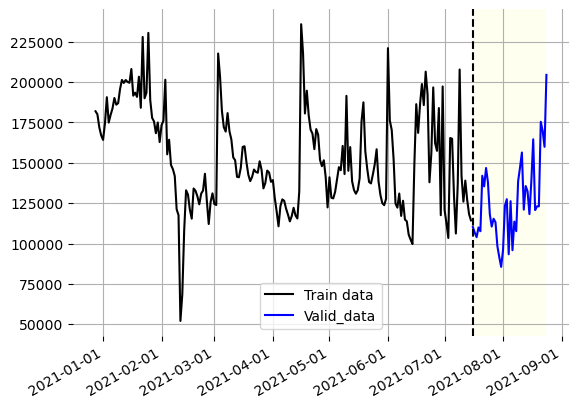

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-200:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data'],
    # date_fmt='%Y-%m-%d %H:%M:%S'  # 支持指定时间格式
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import ModelPipeline, PipelineConfigs

In [8]:
# list all models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'lightgbm',
 'xgboost',
 'wide_gbrt',
 'd_linear',
 'n_linear',
 'n_beats',
 'n_hits',
 'tcn',
 'tft',
 'gau',
 'stacking_rnn',
 'time2vec',
 'multi_output_model',
 'multi_step_model',
 'transformer',
 'random_forest',
 'tide',
 'seg_rnn',
 'prophet']

In [9]:
# If you want to try multiple configurations of a model at once for comparison or tuning purposes, you can use `PipelineConfigs`.
# This feature allows for customizing the models returned by each `ModelPipeline.list_all_available_models()` call.
# The first one is the name of the model, which needs to be in the list of available models provided by PipelineTS.list_all_available_models(). 
# If you want to customize the name of the model, then the second argument can be a string of the model name, 
# otherwise, the second one is of type dict. The dict can have three keys: 'init_configs', 'fit_configs', 'predict_configs', or any combination of them. 
# The remaining keys will be automatically filled with default parameters.
# Among them, 'init_configs' represents the initialization parameters of the model, 'fit_configs' represents the parameters during model training, 
# and 'predict_configs' represents the parameters during model prediction.

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pipeline_configs = PipelineConfigs([
    ('lightgbm', 'lightgbm_linear_tree', {'init_configs': {'verbose': -1, 'linear_tree': True}}),
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
    ('multi_output_model', {
        'init_configs': {'estimator': XGBRegressor, 'random_state': 42, 'kwargs': {'verbosity': 0}}
    }
     ),
    ('multi_output_model', {
        'init_configs': {'estimator': CatBoostRegressor, 'random_state': 42, 'verbose': False}
    }
     ),
])

,model_name,model_name_after_rename,model_configs
0,lightgbm,lightgbm_linear_tree,"{'init_configs': {'verbose': -1, 'linear_tree': True}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
2,multi_output_model,multi_output_model_2,"{'init_configs': {'estimator': <class 'xgboost.sklearn.XGBRegressor'>, 'random_state': 42, 'kwargs': {'verbosity': 0}}, 'fit_configs': {}, 'predict_configs': {}}"
3,multi_output_model,multi_output_model_3,"{'init_configs': {'estimator': <class 'catboost.core.CatBoostRegressor'>, 'random_state': 42, 'verbose': False}, 'fit_configs': {}, 'predict_configs': {}}"
4,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"


In [10]:
from sklearn.metrics import mean_absolute_error
pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    # configs=pipeline_configs, # default to None, it means use the default configs of the model
    include_init_config_model=False,
    use_standard_scale=None,  # False for MinMaxScaler, True for StandardScaler, None means no data be scaled
    include_models='all', # it can be one of the strings ‘light’, ‘all’, ‘nn’, or ‘ml’, or it is of type None or a list. Default to 'light'
    # include_models=['d_linear', 'random_forest', 'n_linear', 'n_beats'],  # specifying the model used
    # exclude_models=['catboost', 'tcn', 'transformer'],  # exclude specified models
    accelerator=accelerator,
    # Now we can directly input the "modelname__'init_params'" parameter to instantiate the models in ModelPipeline.
    # Note that it is double underline. 
    # When it is duplicated with the ModelPipeline class keyword parameter, the ModelPipeline clas keyword parameter is ignored
    # such as :
    # d_linear__lags=50,
    # n_linear__random_state=1024,
    # n_beats__num_blocks=3,
    # random_forest__n_estimators=200
)

In [ ]:
pipeline.fit(data, valid_data=valid_data)

MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:57:03 2023-11-02 - PipelineTS - There are a total of 21 models to be trained.
15:57:03 2023-11-02 - PipelineTS - [model  0] fitting and evaluating auto_arima...
15:57:25 2023-11-02 - PipelineTS - [model  1] fitting and evaluating catboost...
15:59:26 2023-11-02 - PipelineTS - [model  2] fitting and evaluating d_linear...
15:59:45 2023-11-02 - PipelineTS - [model  3] fitting and evaluating gau...
16:00:30 2023-11-02 - PipelineTS - [model  4] fitting and evaluating lightgbm...
16:00:54 2023-11-02 - PipelineTS - [model  5] fitting and evaluating multi_output_model...
16:01:14 2023-11-02 - PipelineTS - [model  6] fitting and evaluating multi_step_model...
16:01:23 2023-11-02 - PipelineTS - [model  7] fitting and evaluating n_beats...
16:01:55 2023-11-02 - PipelineTS - [model  8] fitting and evaluating n_hits...
16:02:16 2023-

In [ ]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)

In [ ]:
# Gets all configurations for the specified model， default to best model
pipeline.get_model_all_configs()

## Model saving and reloading

In [ ]:
from PipelineTS.io import *

In [ ]:
save_model('pipeline.zip', pipeline)
pipeline2 = load_model('pipeline.zip')

In [ ]:
pipeline2.best_model_

In [ ]:
# Gets all configurations for the specified model， default to best model
pipeline2.get_model_all_configs()

In [ ]:
prediction = pipeline2.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)